This notebook build the pipeline of our project from reorganizing (indexing) embedding results  to generating the final dataframe files for R visualization as well as extracting the texts for each news and its comments.


# Import modules

In [ ]:
!pip install tqdm
!pip install spacy_sentiws
!python -m spacy download de
!python -m spacy download de_core_news_md

  Created wheel for spacy-sentiws: filename=spacy_sentiws-0.0.6-cp36-none-any.whl size=3537 sha256=9b87d9e13edaac97519bb180a590ea3ef1b8975e8001b24a0953466239d3ef0e
  Stored in directory: /root/.cache/pip/wheels/cd/d3/36/cc97ed49b6a64788fdd0d0e28abad04accca98aea066a4e47d
Successfully built spacy-sentiws
     |████████████████████████████████| 14.9MB 101.2MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=7b7338e781996e84d5a28f5fce467c3d3fcac869a1275e1adc44068c5c6a60e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-r5vw308u/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
     |██████████████████

In [ ]:
import collections
import pickle
import json
import numpy as np
import pandas as pd
import sklearn
import random
import sys
from tqdm.notebook import tqdm
share_path2 = '/content/drive/My Drive/opinion-lab-group-2.3'
share_path = '/content/drive/My Drive/Colab Notebooks/opinion-lab-group-2.3'
from google.colab import drive
drive.mount('/content/drive')
#sys.path.append(share_path)
sys.path.append(share_path2)
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import nltk
import spacy
import src.organizer as organizer
import src.kmeancluster as kmeancluster
import src.twgenerator as twgenerator
import src.sentiment as sentiment
import src.distribution as distribution
import os
nyfile = share_path2+ '/output_emb/nytimes-compact-embeddings.json' 
spfile = share_path2+ '/output_emb/spiegel-compact-embeddings.json' 
qufile = share_path2+ '/output_emb/quora-relevant-embeddings.json' 

tokenfile = 'output_emb/all_sentence_tokens.json'
#jsonfilelist = {'quora': qufile} # {'spiegel':spfile}
jsonfilelist= {'nytimes': nyfile,'quora': qufile,'spiegel':spfile}

### generate a test file to check if it correct

# Reorganizing the embs.json files. 
Divided into three files:
1. emb.json
2. str.json
3. ind.json

from all 3 emb.jsons to generate the global_ind.json

In [ ]:
organizer_index = organizer.CorpusOrganizer()
organizer_index.create_index_str_file(jsonfilelist,suffix='updated')

begin:  nytimes
Finished corpus nytimes with sentence_id 0  to sentence_id 77022 
begin:  quora
Finished corpus quora with sentence_id 77023  to sentence_id 136424 
begin:  spiegel
Finished corpus spiegel with sentence_id 136425  to sentence_id 353785 
All 353785 sentences indexes successfully generated.
All 353785 sentences strings successfully generated.


option: outside output

# Import sentences_string from json

In [ ]:
strfile = '/output_emb/all_sentences_str.json'
sen_str_ls = organizer.json2list(share_path2+strfile)
print(len(sen_str_ls))

353786


## count http link sentences


In [ ]:
http_num = 0
http_num_nytimes = 0
http_num_quora = 0
http_num_spiegel = 0
for s in ls:
  for key, value in s.items():
    if 'href=' in value:
      http_num += 1
      if int(key) <= 77022:
        http_num_nytimes += 1
        # print('<li>', value, '</li>')
      elif int(key) >= 136425:
        http_num_spiegel += 1
      else:
        http_num_quora += 1
    
print('Precentage among all sentences: {} %'.format(http_num/353786 * 100))
print('Precentage among NYTimes sentences: {} %'.format(http_num_nytimes/77023 * 100))
print('Precentage among Quora sentences: {} %'.format(http_num_quora))
print('Precentage among Die Spiegel sentences: {} %'.format(http_num_spiegel))



Precentage among all sentences: 0.19842503660404878 %
Precentage among NYTimes sentences: 0.9114160705243889 %
Precentage among Quora sentences: 0 %
Precentage among Die Spiegel sentences: 0 %


# Tokenizing all sentences into words

### Using [RegexpTokenizer](https://www.nltk.org/_modules/nltk/tokenize/regexp.html)

Regular-Expression Tokenizers

A ``RegexpTokenizer`` splits a string into substrings using a regular expression.
For example, the following tokenizer forms tokens out of alphabetic sequences,
money expressions, and any other non-whitespace sequences:

```    >>> from nltk.tokenize import RegexpTokenizer
    >>> s = "Good muffins cost $3.88\nin New York.  Please buy me\ntwo of them.\n\nThanks."
    >>> tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    >>> tokenizer.tokenize(s)
    ['Good', 'muffins', 'cost', '$3.88', 'in', 'New', 'York', '.',
    'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']
```

## output the tokens.json




version 1 : stopwords from nltk

(duration 16:42)



version 2 : stopwords from spacy

(duration 00:30)

kmeans cluster result for extracting topwords in each cluster

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
#tokens = organizer.json2list(share_path2+'all_tokens_spacy_stemmed.json')
singles = [stemmer.stem(t) for t in token_de]
token_de = tokens[136456]['136456']

['meist',
 'fragten',
 'verwirrt',
 'verbrauch',
 'innen-',
 'verbraucherschutzministerium',
 'qualität',
 'baden-württemberg',
 'bürge']

# Sentiment scoring

## first try: vadar


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 133kB 4.8MB/s 


In [ ]:
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()
#vs = analyzer.polarity_scores(test_sentence)
#print("{:-<20} {}".format(sentence, str(vs)))
vader_res = []
for i, sen in enumerate(sen_str_ls[:10]):
  sentence = sen[str(i)]
  vader_res.append(analyzer.polarity_scores(sentence))


In [ ]:
sen_str_ls[1]

{'1': "Through a deal with Green Mountain Coffee Roasters and Newman's Own, McDonald's will soon be serving a coffee that comes from organic beans and is certified Fair Trade because it meets higher standards in the treatment of coffee workers."}

In [ ]:
pickle.dump(vader_res,open(share_path2+'/vader_res.pkl','wb'))

In [ ]:
vader_res

[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.3182, 'neg': 0.0, 'neu': 0.943, 'pos': 0.057},
 {'compound': 0.4215, 'neg': 0.055, 'neu': 0.809, 'pos': 0.136},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.4005, 'neg': 0.0, 'neu': 0.899, 'pos': 0.101},
 {'compound': 0.6249, 'neg': 0.0, 'neu': 0.773, 'pos': 0.227},
 {'compound': 0.0, 'neg': 0.099, 'neu': 0.802, 'pos': 0.099}]

## second try: sentiwordnet

In [ ]:
from nltk.corpus import sentiwordnet as swn
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### test one sentence


In [ ]:
sen_str_ls[0]
test_sentence = sen_str_ls[353777]['353777']
ss = sentiment.sentence_sentiment(test_sentence,'de')

'Mit einer FINANZtest-Bewertung von 77,1 Punkte ist der Pioneer Global Ecology Börsen-Chart zeigen ein "stark überdurchschnittlicher" Fonds.'

### sentiment all sentences from str.json 

In [ ]:
sentiwordnet_res_en_de = []
for i, sen in tqdm(enumerate(sen_str_ls)):
  sentence = sen[str(i)]
  if i>=136425:
    sentiwordnet_res_en_de.append(sentiment.sentence_sentiment(sentence,'de'))
  else:
    sentiwordnet_res_en_de.append(sentiment.sentence_sentiment(sentence,'en'))


In [ ]:
pickle.dump(sentiwordnet_res_en_de,open(share_path2+'/sentiwordnet_res_en_de.pkl','wb'))



pickle.dump(sentiwordnet_res_en_de,open(share_path2+'/sentiwordnet_res_en_de.pkl','wb'))



In [ ]:
sentiwordnet_res_en_de = pickle.load(open(share_path2+'/sentiwordnet_res_en_de.pkl','rb'))



### tracking back sentiwordnet for sentences


In [ ]:
for i, score in enumerate(sentiwordnet_res_en_de[:100]):
  if score>0.3:
    print(sen_str_ls[i][str(i)] + ': ',score)

General Mills markets the Cascadian Farms and Muir Glen brands; Kraft owns Back to Nature and Boca Foods, which makes soy burgers.:  0.5
But the sector's growing appeal to consumers has fueled a 20 percent annual growth rate in recent years, making it highly attractive to food giants looking for gains in a slow-moving business.:  0.375
Ronnie Cummins, national director of the Organic Consumers Association, calls the initiative a "sneak attack engineered by the likes of Kraft, Dean Foods and Smucker's.".:  0.34375
Many in the organic industry say they are willing to allow some use of synthetics in organic food.:  0.3125
"Wal-Mart allows you to really build market share," Mr. Simeon said.:  0.625
"We want to meet the regulations," said Kelly O'Shea, Horizon's director of government and industry relations, "and see integrity in the organic standards.".:  0.4375
Aurora executives say that despite the lack of pasture, their cows are "very healthy and happy.":  0.375
The man up in Mount Kisc

# Integrating cluster and sentiment into (k= 16 ) index dictionary

## define the aspects for each cluster and legal clusters (exclude garbage cluster)

In [ ]:

aspects_old ={0: 'garbage1',1:'Planting & gardening',2:'garbage2',3:'Chemicals & Cancer',4:'Meat & Animals',5:'Taste & Food',6:'Health & Diet',7:'Retail',8:'Scientific Research',9:'GMO',10:'Skandals',11:'Agriculture',12:'Polices',13:'Economy',14:'garbage3',15:'garbage4'}
legal_clusters = {}
for key in aspects:
  if 'garbage' not in aspects[key]:
      legal_clusters[key] = aspects[key]
print(legal_clusters)

{1: 'Planting & gardening', 3: 'Chemicals & Cancer', 4: 'Meat & Animals', 5: 'Taste & Food', 6: 'Health & Diet', 7: 'Retail', 8: 'Scientific Research', 9: 'GMO', 10: 'Skandals', 11: 'Agriculture', 12: 'Polices', 13: 'Economy'}


backup:{1: 'Evironment & gardening & chemicals',
 3: 'Human health & disease',
 4: 'Animal welfares & meat consumption',
 6: 'Nutrition & lifestyle',
 7: 'retailers & brands',
 8: 'Evidence',
 9: 'GMO & Chemicals',
 11: 'Production & Agriculture',
 12: 'Politics',
 13: 'Economy & Costs'}

### check the number of sentences in each cluster

In [ ]:
#local_drive_path = '/content/drive/My Drive/'
#for i in range():
i=16
file_name = '/kmean-output_{}-kmean-cluster_data_index_dic.txt'.format(i)
dic = organizer.txt2dic(share_path2+file_name)
for key in dic:
  print('{} cluster has {} sentences.'.format(key,len(dic[key])))

7 cluster has 16374 sentences.
9 cluster has 28712 sentences.
12 cluster has 24222 sentences.
11 cluster has 25084 sentences.
0 cluster has 27901 sentences.
3 cluster has 24030 sentences.
15 cluster has 29389 sentences.
14 cluster has 30455 sentences.
13 cluster has 21123 sentences.
6 cluster has 21511 sentences.
4 cluster has 19171 sentences.
1 cluster has 18867 sentences.
5 cluster has 21887 sentences.
8 cluster has 17412 sentences.
10 cluster has 7180 sentences.
2 cluster has 20468 sentences.


## Generate labels for each sentence and add label and sentiment score in index_df

In [ ]:
#lfile = '/content/drive/My Drive/opinion-lab-group-2.3/kmean-output/' + str(16) + '-kmean-labels.txt'
index_jsonfile_path = "/content/drive/My Drive/opinion-lab-group-2.3/refactorization/data/sentence_cluster_sentiment_dict.json"
#sentiwordnet_result_pkl_path = share_path2+'/sentiwordnet_res_en_de.pkl'
ind_df = pd.DataFrame(organizer.json2list(index_jsonfile_path))

In [ ]:
#%time ind_df = distribution.add_sentiment2index(lfile, index_jsonfile_path,sentiwordnet_result_pkl_path)


### tracking back to sentence

In [ ]:
test_id = 136621
print(sen_str_ls[test_id])
ind_df[(ind_df['global_id']==test_id) ]


In [ ]:
max(ind_df[ind_df.corpus_name=='nytimes'].doc_id)

326

### latex for dataframe

In [ ]:
print(ind_df[(ind_df['global_id']==30120)].to_latex())
sen_str_ls[30120]

# Selecting no_garbage docs for news and comments

In [ ]:
aspects ={0: 'Planting & gardening',
1: 'Retail',
3: 'GMO label & bio-products',
5: 'Taste & food',
6: 'Chemicals & cancer',
7: 'Genetic research',
8: 'Health & diet',
10: 'Governance & public policy',
11: 'Meat & animal feeding',
12: 'Agriculture',
13: 'Price & consumption'}
ind_df.head()

,global_id,corpus_name,doc_id,com_id,date,cluster,sentiment
0,0,nytimes,0,-1,2005-11-01,1,0.12500
1,1,nytimes,0,-1,2005-11-01,1,-0.12500
2,2,nytimes,0,-1,2005-11-01,3,0.07500
3,3,nytimes,0,-1,2005-11-01,1,0.50000
4,4,nytimes,0,-1,2005-11-01,1,-0.03125


In [ ]:
ind_df.com_id.unique()

array([  -1,    0,    1, ..., 3809, 3810, 3811])

In [ ]:
%time docs_list_no_garbage = distribution.generate_documents_statistic(ind_df)


In total there are 913 articles .
nytimes has 327 articles.
quora has 434 articles.
spiegel has 152 articles.
CPU times: user 18 s, sys: 25.8 ms, total: 18 s
Wall time: 18 s
In total there are 1075 articles with comments.
nytimes has 93 articles.
quora has 922 articles.
spiegel has 60 articles.
CPU times: user 13.1 s, sys: 11.6 ms, total: 13.1 s
Wall time: 13.1 s


In [ ]:
%time coms_list_no_garbage = distribution.generate_documents_statistic(ind_df, comment=True)

[   0    1    2 ... 3809 3810 3811]
In total there are 1448 articles with comments.
nytimes has 99 articles.
quora has 1288 articles.
spiegel has 61 articles.
CPU times: user 37.6 s, sys: 32.2 ms, total: 37.6 s
Wall time: 37.6 s


In [ ]:


pickle.dump(docs_list_no_garbage,open(share_path2+'/output_lists_no_garbage/docs_list_no_garbage.pkl','wb'))
pickle.dump(coms_list_no_garbage,open(share_path2+'/output_lists_no_garbage/coms_list_no_garbage.pkl','wb'))

In [ ]:
docs_list_no_garbage = pickle.load(open(share_path2+'/output_lists_no_garbage/docs_list_no_garbage.pkl','rb'))
coms_list_no_garbage = pickle.load(open(share_path2+'/output_lists_no_garbage/coms_list_no_garbage.pkl','rb'))

In [ ]:
len(docs_list_no_garbage)

913

In [ ]:
docs_list_no_garbage[0]

{'article_df':       scores    weight  cluster      mean       var        date
 0   0.125000  0.230769        1  0.148750  0.043600  2005-11-01
 1  -0.125000  0.230769        1  0.148750  0.043600  2005-11-01
 2   0.500000  0.230769        1  0.148750  0.043600  2005-11-01
 3  -0.031250  0.230769        1  0.148750  0.043600  2005-11-01
 4   0.000000  0.230769        1  0.148750  0.043600  2005-11-01
 ..       ...       ...      ...       ...       ...         ...
 11  0.125000  0.215385       12  0.021875  0.022330  2005-11-01
 12 -0.093750  0.215385       12  0.021875  0.022330  2005-11-01
 13  0.075000  0.215385       12  0.021875  0.022330  2005-11-01
 0   0.020833  0.030769       13  0.072917  0.002713  2005-11-01
 1   0.125000  0.030769       13  0.072917  0.002713  2005-11-01
 
 [65 rows x 6 columns], 'corpus': 'nytimes', 'doc_id': 0}

In [ ]:
coms_list_no_garbage[0]

{'comments_df':    scores    weight  cluster     mean       var        date
 0   0.125  0.333333        1  0.18750  0.003906  2017-10-11
 1   0.250  0.333333        1  0.18750  0.003906  2017-10-11
 0   0.125  0.666667        5  0.10625  0.015117  2017-10-11
 1   0.300  0.666667        5  0.10625  0.015117  2017-10-11
 2   0.000  0.666667        5  0.10625  0.015117  2017-10-11
 3   0.000  0.666667        5  0.10625  0.015117  2017-10-11,
 'corpus': 'quora',
 'doc_id': 0}

In [ ]:
len(coms_list_no_garbage)

1448

### Select the article with more than num = 1 sentences of comment





In [ ]:
output_df = share_path2+'/refactorization/output/'

In [ ]:
num = 1
%time all_nytimes_manycomments,all_nytimes_many_id_list,all_comments_sentences = distribution.select_articles_with_many_comments_from_one_corpous(docs_list_no_garbage,coms_list_no_garbage,output_path=output_df,corpus_name='nytimes',num_comments=num)


In [ ]:
len(all_nytimes_manycomments)

99

In [ ]:
%time all_spiegel_manycomments,all_spiegel_many_id_list,_ = distribution.select_articles_with_many_comments_from_one_corpous(docs_list_no_garbage,coms_list_no_garbage,output_path= output_df,corpus_name='spiegel')

DescribeResult(nobs=61, minmax=(9, 19965), mean=1989.655737704918, variance=19296695.92950819, skewness=3.00073777640711, kurtosis=7.548302220187582)
626.0
CPU times: user 1.18 s, sys: 57.9 ms, total: 1.24 s
Wall time: 1min 20s


In [ ]:
len(all_spiegel_many_id_list)

61

In [ ]:
print(all_nytimes_many_id_list)

[40, 57, 76, 127, 131, 133, 147, 162, 167, 175, 177, 196, 214, 216, 222, 229, 231, 245, 254, 259, 264, 282, 304, 309, 316, 320, 321, 322, 323, 324, 325, 326]


## Generating sentiment statistics for docs to DataFrame ( .csv for R)

In [ ]:
doc_ny_df, doc_sp_df = distribution.accumulate_sentiment_scores_on_ny_sp(docs_list_no_garbage,output_path=output_df)

mean of nytimes: 0.054464934641703294
var of nytimes: 0.03981421116386781
quantile of nytimes: [-0.1875  0.275 ]
mean of spiegel: -0.03252244875433617
var of spiegel: 0.036865097604611714
quantile of spiegel: [-0.28521333  0.15277   ]


In [ ]:
comm_ny_df, comm_sp_df = distribution.accumulate_sentiment_scores_on_ny_sp(coms_list_no_garbage,comment=True,output_path=output_df)

mean of nytimes comments : 0.028865004151744398
var of nytimes comments : 0.045588797802473276
quantile of nytimes comments : [-0.25  0.25]
mean of spiegel comments : -0.03792295028287614
var of spiegel comments : 0.039416774964246684
quantile of spiegel comments : [-0.3125      0.12653333]


In [ ]:
print(np.mean(sen_score_doc_sp))
print(np.var(sen_score_doc_sp))

0.03947639547645116

## Tracking back to article

In [ ]:
%time data_emb_ny=organizer.json2list(nyfile)

In [ ]:
for num in all_nytimes_many_id_list:
  text_file = open(share_path2+"/output_df_article_comments_sentiment/article_nytimes_{}.txt".format(num), "w")
  text_file.write(data_emb_ny[num]['article_text'])
  text_file.close()

In [ ]:
%time data_emb_sp=organizer.json2list(spfile)


CPU times: user 52.7 s, sys: 6.56 s, total: 59.2 s
Wall time: 1min 20s


In [ ]:
len(data_emb_sp)

152

In [ ]:
for num in all_nytimes_many_id_list:
  comments_texts = []
  path = share_path2+"/output_df_article_comments_sentiment/comments_nytimes_{}.txt".format(num)
  if os.path.isfile(path):
    text_file = open(path, "w")
    print('overwrite')
  else:
    text_file = open(path, "a")
  for com in data_emb_ny[num]['comments']:
    text_file.write(com['comment_text'])
    text_file.write('\n')
text_file.close()
    

In [ ]:
for num in all_spiegel_many_id_list:
  comments_texts = []
  path = share_path2+"/output_articles_comments/comments_spiegel_{}.txt".format(num)
  if os.path.isfile(path):
    text_file = open(path, "w")
    print('overwrite')
  else:
    text_file = open(path, "a")
  for com in data_emb_sp[num]['comments']:
    text_file.write(com['comment_text'])
    text_file.write('\n')
text_file.close()
    

overwrite


In [ ]:
for num in all_spiegel_many_id_list:
  path = share_path2+"/output_articles_comments/article_spiegel_{}.txt".format(num)
  if not os.path.isfile(path):
    text_file = open(path, "w")
    text_file.write(data_emb_sp[num]['article_text'])
  text_file.close()

# backup

In [ ]:
def interset_dic(set1,set2):
  interset = list(set1 & set2) 
  new_d = {}
  for i in interset:
    new_d[i] = legal_clusters[i]
  return new_d
def normalize(x):
    """normaliaztion"""
    #print('x is: ',x)
    return x/ abs(x).sum()
    
def normalization(df):
  df_new_t = df.T
  
  all_abs_sum = sum(df_new_t[0])
  #print('all_abs_sum: ', all_abs_sum)
  df_new_t['normalized_pos'] = (df_new_t[1])/all_abs_sum
  df_new_t['normalized_neg'] = (df_new_t[2])/all_abs_sum
  #print(df_new_t['normalized'], 'sum: ', df_new_t['normalized'].sum())
  return df_new_t

In [ ]:
%%time 
docs_distribution=[]
for doc in docs_list_no_garbage:
  doc_normalized = {}
  doc_normalized['doc_id'] = doc['doc_id']
  doc_normalized['corpus'] = doc['corpus']
  df = pd.DataFrame(doc).drop(['doc_id','corpus'],axis=1)
  set1= set(list(df.columns))
  fullcols = set(legal_clusters.keys())
  #dt_new = df[set1 & set2].rename(columns=interset_dic(set1,set2))
  #print(dt_new.head())
  df_new = df[set1 & fullcols].rename(columns=interset_dic(set1,fullcols)) #.rename(columns=new_d)
  df_new_t = normalization(df_new)
  dic = df_new_t[['normalized_pos','normalized_neg']].to_dict()
  #print(df_new_t[['normalized_pos','normalized_neg']].to_latex())
  doc_normalized.update(dic)
  docs_distribution.append(doc_normalized)

Streaming output truncated to the last 5000 lines.
{} &  normalized\_pos &  normalized\_neg \\
\midrule
Planting \& gardening &        0.188664 &       -0.061311 \\
Chemicals \& Cancer   &        0.020320 &       -0.029915 \\
Meat \& Animals       &        0.000000 &       -0.017518 \\
Taste \& Food         &        0.228779 &       -0.080456 \\
Health \& Diet        &        0.148899 &       -0.021021 \\
Retail               &        0.023123 &        0.000000 \\
Scientific Research  &        0.026276 &       -0.022335 \\
GMO                  &        0.078829 &       -0.021897 \\
Agriculture          &        0.017518 &       -0.013138 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  normalized\_pos &  normalized\_neg \\
\midrule
Scientific Research &             1.0 &             0.0 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  normalized\_pos &  normalized\_neg \\
\midrule
Planting \& gardening &        0.037672 &        0.000000 \\
Chemicals \

In [ ]:

for key in (legal_aspects-z.keys()):
  z[key] = int(0)
  pos_z[key] = int(0)
print(pos_z)

{'Planting & gardening': 0.0, 'Chemicals & Cancer': 0.0, 'Health & Diet': 0.3544467088717371, 'Retail': 0.027317665423640624, 'Scientific Research': 0.0921971208047871, 'GMO': 0.004552944237273438, 'Agriculture': 0.07740005203364843, 'Polices': 0.06829416355910156, 'Economy': 0.0, 'Taste & Food': 0, 'Skandals': 0, 'Meat & Animals': 0}


In [ ]:
legal_aspects = list(legal_clusters.values())
def radar_plot_one(doc,N=12,feature =legal_aspects):
  plt.style.use('ggplot')
  doc_id = doc['doc_id']
  corpus = doc['corpus']
  z = doc['normalized_neg']
  pos_z = doc['normalized_pos']
  key_list = list(z.keys())
  for key in (legal_aspects-z.keys()):
    z[key] = int(0)
    pos_z[key] = int(0)
  value_list = np.array(list(z.values()))*(-1)
  value_list_pos = list(pos_z.values())
  values = value_list
  values2 = value_list_pos
  max_v = max(max(values),max(values2))
  angles=np.linspace(0, 2*np.pi, N, endpoint=False)

  values=np.concatenate((values,[values[0]]))
  values2=np.concatenate((values2,[values2[0]]))
  angles=np.concatenate((angles,[angles[0]]))
  fig=plt.figure()
  ax = fig.add_subplot(111, polar=True)
  ax.plot(angles, values, 'o-', linewidth=2,label='negative')
  ax.fill(angles, values, alpha=0.25)
  ax.plot(angles, values2, 'o-', linewidth=2, label = 'positive')
  ax.fill(angles, values2, alpha=0.25)
  ax.legend(loc='lower left')
  ax.set_thetagrids(angles * 180/np.pi, feature)
  
  ax.set_ylim(0,max_v)
  ax.set_title('Sentiment Distribution across 12 aspects for article {} in {}\n'.format(doc_id,corpus))
  ax.grid(True)
  plt.tight_layout()
  fig.savefig(share_path2+'/output_distribution/radar/radar_{}_{}.png'.format(corpus,doc_id), bbox_inches = 'tight')

## plot sentiment distribution per doc

In [ ]:
def plot_single_doc(doc):
  df = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
  ax = df.T.plot(kind='bar',width=0.6)
  ax.set_title('Document from {}: {}'.format(doc['corpus'],doc['doc_id']))


def plot_one_doc(doc):
  df = pd.DataFrame(doc,index=[0])
  df_t = df.drop(['doc_id','corpus'],axis=1).T
  df_t['positive']=df_t[0]>0
  corpus =df.corpus.values[0]
  doc_id = df.doc_id.values[0]
  ax = df_t.plot(kind='bar',color=[df_t['positive'].map({True: 'lightblue', False: 'orange'})],figsize=(10,5),legend=False)
  fig = ax.get_figure()
  ax.set_title('Sentiment Distribution from {}:{}'.format(corpus,doc_id))
  ax.grid(True,axis='y',zorder=0,ls='--')
  fig.savefig(share_path2+'/output_distribution/distribution_{}_{}.png'.format(corpus,doc_id), bbox_inches = 'tight')

def concat_pos_neg(df_init):
  df_nytimes_pos = df_init[df_init>0].sum()
  df_nytimes_neg = df_init[df_init<0].sum()
  df = pd.concat([pd.DataFrame(df_nytimes_pos).T, pd.DataFrame(df_nytimes_neg).T],  sort=False)
  df.index = ['positive','negative']
  return df

In [ ]:
for doc in docs_distribution:
  radar_plot_one(doc)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for doc in docs_distribution:
  if doc['corpus']== 'nytimes':
    if doc['doc_id']==0:
      df_init_nytimes = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
    else:
      df_new = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
      df_init_nytimes = pd.concat([df_init_nytimes, df_new],  sort=False)
  elif doc['corpus']== 'quora':
    if doc['doc_id']==7: # the first docid in quora
      df_init_quora = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
    else:
      df_new = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
      df_init_quora = pd.concat([df_init_quora, df_new],  sort=False)
  elif doc['corpus']== 'spiegel':
    if doc['doc_id']==0:
      df_init_spiegel = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
    else:
      df_new = pd.DataFrame(doc,index=[0]).drop(['doc_id','corpus'],axis=1)
      df_init_spiegel = pd.concat([df_init_spiegel, df_new],  sort=False)

   normalized_pos  normalized_neg
0             NaN             NaN


In [ ]:
def inital_df(doc):
  df_init_nytimes = pd.DataFrame(doc['normalized_pos'],index=[0])
  df_init_neg_nytimes = pd.DataFrame(doc['normalized_neg'],index=[0])
  df_init_nytimes = pd.concat([df_init_nytimes, df_init_neg_nytimes],  sort=False)
  return df_init_nytimes

In [ ]:
for doc in docs_distribution:
  if doc['corpus']== 'nytimes':
    if doc['doc_id']==0:
      df_init_nytimes= inital_df(doc)
    else:
      df_new_nytimes = inital_df(doc)
      df_init_nytimes = pd.concat([df_init_nytimes, df_new_nytimes],  sort=False)
  elif doc['corpus']== 'quora':
    if doc['doc_id']==7: # the first docid in quora
      df_init_quora = inital_df(doc)
    else:
      df_new = inital_df(doc)
      df_init_quora = pd.concat([df_init_quora, df_new],  sort=False)
  elif doc['corpus']== 'spiegel':
    if doc['doc_id']==0:
      df_init_spiegel = inital_df(doc)
    else:
      df_new = inital_df(doc)
      df_init_spiegel = pd.concat([df_init_spiegel, df_new],  sort=False)

In [ ]:
df_init_nytimes

,Chemicals & Cancer,Meat & Animals,Health & Diet,Retail,GMO,Agriculture,Polices,Economy
0,0.000000,0.035643,0.0,0.237620,0.200407,0.095048,0.060395,0.013861
0,-0.005941,-0.011881,0.0,-0.025544,-0.259600,-0.054059,0.000000,0.000000


In [ ]:
df_nytimes_pn = concat_pos_neg(df_init_nytimes)
df_quora_pn = concat_pos_neg(df_init_quora)
df_spiegel_pn = concat_pos_neg(df_init_spiegel)

In [ ]:
print(df_nytimes_pn)

,Chemicals & Cancer,Meat & Animals,Health & Diet,Retail,GMO,Agriculture,Polices,Economy,Scientific Research,Planting & gardening,Taste & Food,Skandals
positive,6.472294,5.172971,19.148101,40.137596,28.375262,25.826094,9.012425,9.602750,7.150391,8.829493,11.046587,0.000000
negative,-9.313127,-7.231478,-14.540219,-28.584919,-24.229253,-21.517220,-12.172925,-8.614077,-5.877933,-12.380440,-10.576382,-0.188059


In [ ]:
docs_nytimes = []
docs_spiegel = []
for doc in docs_distribution:
  if doc['corpus']== 'nytimes':
    docs_nytimes.append(doc)

In [ ]:
%%time
for doc in tqdm(docs_distribution):
  plot_one_doc(doc)

Output hidden; open in https://colab.research.google.com to view.

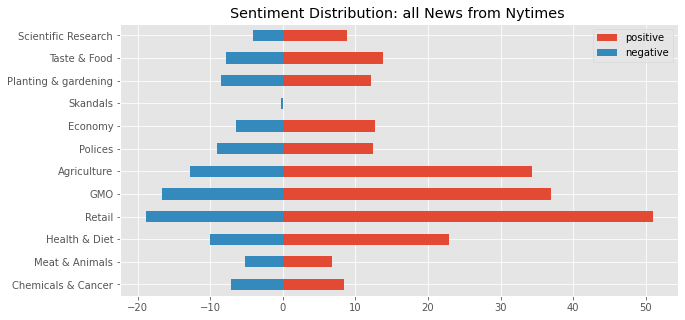

In [ ]:

ax = df_nytimes_pn.T.plot.barh(stacked = True,figsize=(10,5))
ax.set_title('Sentiment Distribution: all News from Nytimes ')
fig = ax.get_figure()
fig.savefig(share_path2+'/nytimes_sentiments_2.png', bbox_inches = 'tight')

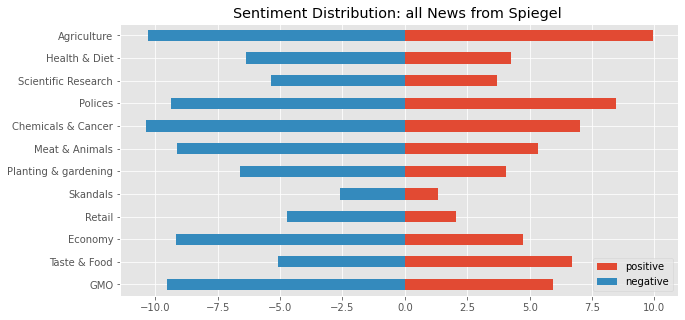

In [ ]:
ax = df_spiegel_pn.T.plot.barh(stacked = True,figsize=(10,5))
ax.set_title('Sentiment Distribution: all News from Spiegel ')
fig = ax.get_figure()
fig.savefig(share_path2+'/spiegel_sentiments_2.png', bbox_inches = 'tight')

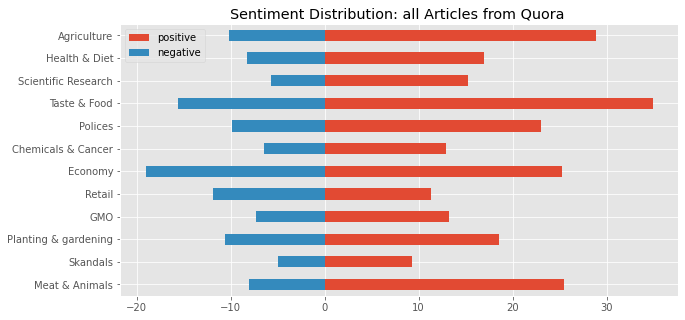

In [ ]:
ax = df_quora_pn.T.plot.barh(stacked = True,figsize=(10,5))
ax.set_title('Sentiment Distribution: all Articles from Quora ')
fig = ax.get_figure()
fig.savefig(share_path2+'/quora_sentiments_2.png', bbox_inches = 'tight')

   doc_id   corpus  ...  Production & Agriculture  Economy & Costs
0       1  nytimes  ...                 -0.088059        -0.058706

[1 rows x 10 columns]


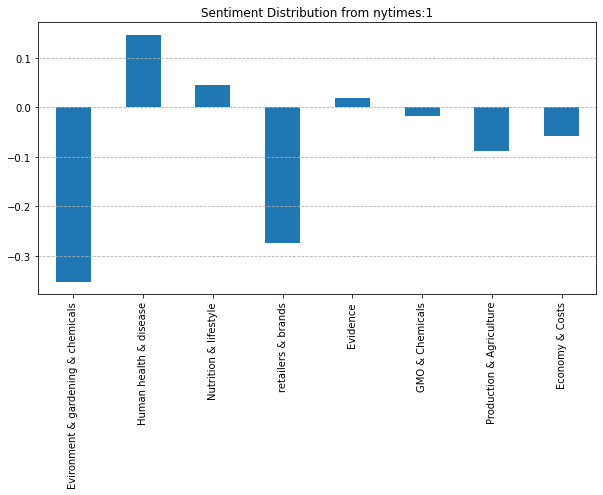

In [ ]:
docs_distribution[2]['doc_id']

1

In [ ]:
nytimes_doc = {}
quora_doc = {}
spiegel_doc = {}
for doc in docs_distribution:
  if doc['corpus']== 'nytimes':
    print(doc)
  

{'doc_id': 0, 'corpus': 'nytimes', 'Human health & disease': -0.06326323255947701, 'Animal welfares & meat consumption': 0.012652646511895403, 'Nutrition & lifestyle': -0.025305293023790806, 'retailers & brands': 0.36945727814734575, 'GMO & Chemicals': -0.35448497977493626, 'Production & Agriculture': -0.08205049556198837, 'Politics': 0.08435097674596935, 'Economy & Costs': 0.008435097674596935}
{'doc_id': 1, 'corpus': 'nytimes', 'Evironment & gardening & chemicals': -0.35223407724921957, 'Human health & disease': 0.14676419885384148, 'Nutrition & lifestyle': 0.044029259656152446, 'retailers & brands': -0.27330755253226485, 'Evidence': 0.019568559847178868, 'GMO & Chemicals': -0.017332153007501284, 'Production & Agriculture': -0.08805851931230489, 'Economy & Costs': -0.0587056795415366}
{'doc_id': 2, 'corpus': 'nytimes', 'Evidence': 0.28124999999999994, 'Production & Agriculture': -0.53125, 'retailers & brands': 0.18749999999999997}
{'doc_id': 3, 'corpus': 'nytimes', 'Evironment & gard

In [ ]:
plot()

In [ ]:
organizer.json2list(share_path2+'/nytimes.json')[191]

{'article_author': [{'article_author_name': 'Andrew Goldman'}],
 'article_source': 'NY Times',
 'article_text': 'In your new book, “Conscious Capitalism,” you write that Whole Foods sees its customers as its “most important stakeholders” and that the company is obsessed with their happiness. The biggest complaint I hear about Whole Foods is how expensive it is. Why not drop prices to make your customers happier? People always complain about prices being too high. Whole Foods prices have dropped every year as we get to be larger and we have economies of scale. Also, people are not historically well informed about food prices. We’re only spending about 7 percent of our disposable personal income on food. Fifty years ago, it was nearly 16 percent.\nA paper from Stanford last year concluded that there is little evidence of greater health benefits from eating organic. If it were ever definitively proved that organic foods offered no health benefits, would you still be a proponent? Oh, absol

In [ ]:
doc_df[(doc_df.doc_id==191) & (doc_df.corpus_name=='nytimes')]

,global_id,corpus_name,doc_id,com_id,cluster,sentiment
30109,30109,nytimes,191,NaN,7,0.000000
30110,30110,nytimes,191,NaN,7,-0.750000
30111,30111,nytimes,191,NaN,5,0.250000
30112,30112,nytimes,191,NaN,7,-0.375000
30113,30113,nytimes,191,NaN,7,0.250000
30114,30114,nytimes,191,NaN,7,-0.208333
30115,30115,nytimes,191,NaN,7,0.125000
30116,30116,nytimes,191,NaN,7,-0.025000
30117,30117,nytimes,191,NaN,7,-0.225000
30118,30118,nytimes,191,NaN,13,0.625000


## generating the rough toplist for each cluster
### deleting the common words which are defined by two methods in twGenerator in each toplist

In [ ]:
twGenerator = twgenerator.TWGenerator(output_path=share_path2)
%time twGenerator.load_sentence_strs(sen_str_ls)


token::::



CPU times: user 23.5 s, sys: 563 ms, total: 24.1 s
Wall time: 24.8 s


## word cloud generator based on filtered top words list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
for i in range(11,13):
  print('k= ',i)
  file_name = share_path2 +'/kmean-output_{}-kmean-cluster_data_index_dic.txt'.format(i)
  %time twGenerator.load_clusters(clusters_dic_path=file_name)
  %time twGenerator.load_commonwords() 
  %time twGenerator.generate_tops_in_clusters()
  %time twGenerator.wordcloud(3,4,(30,20))


Output hidden; open in https://colab.research.google.com to view.

k=  9
it has 9 clusters
CPU times: user 1.43 s, sys: 112 ms, total: 1.54 s
Wall time: 1.54 s
CPU times: user 1.36 s, sys: 9.03 ms, total: 1.37 s
Wall time: 1.38 s
                 0                  1  ...                    7                    8
0      (eat, 1953)        (gmo, 2799)  ...       (product, 322)       (product, 527)
1  (product, 1524)    (product, 2749)  ...  (lebensmittel, 291)          (farm, 463)
2     (farm, 1167)     (health, 1746)  ...          (farm, 271)  (lebensmittel, 341)
3   (health, 1070)        (eat, 1619)  ...       (produkt, 267)           (bio, 333)
4      (good, 741)  (pesticide, 1257)  ...           (bio, 245)        (health, 302)

[5 rows x 9 columns]
same_words
{'eat': 9, 'product': 9, 'farm': 9, 'health': 9, 'good': 9, 'grow': 9, 'buy': 8, 'fruit': 9, 'taste': 5, 'pesticide': 9, 'lebensmittel': 9, 'better': 9, 'use': 9, 'bio': 9, 'store': 6, 'know': 9, 'fresh': 2, 'time': 9, 'vegetables': 6, 'nutrition': 8, 'local': 7, 'natural': 9, 'produkt': 9, 'm

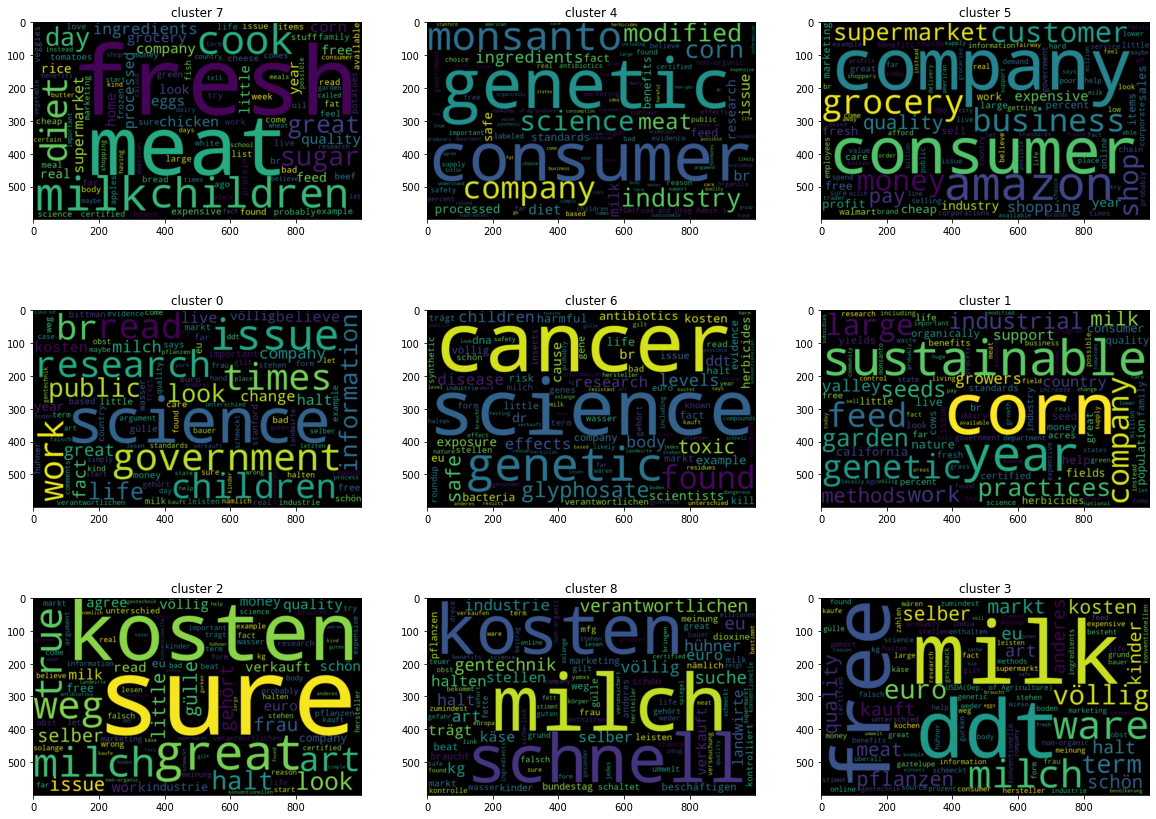

In [ ]:
for i in range(9,10):
  print('k= ',i)
  file_name = share_path2 +'/kmean-output_{}-kmean-cluster_data_index_dic.txt'.format(i)
  %time twGenerator.load_clusters(clusters_dic_path=file_name)
  %time twGenerator.load_commonwords() 
  %time twGenerator.generate_tops_in_clusters()
  %time twGenerator.wordcloud(3,3,(20,15))

## randomly extract sentences examples

In [ ]:
for i in range(16,17):
    file_name = share_path2 +'/kmean-output_{}-kmean-cluster_data_index_dic.txt'.format(i)
    dic = organizer.txt2dic(file_name)
    with open(share_path2 +'/kmean-output/cluster_{}_sentences_examples.txt'.format(i), 'w') as f:
      for key in dic:
        indx = random.sample(dic[key],20)
        print('cluster ',key)
        f.write('cluster '+str(key)+'\n')
        for sen in indx:
          f.write(str(sen_str_ls[sen])+'\n')

cluster  7
cluster  9
cluster  12
cluster  11
cluster  0
cluster  3
cluster  15
cluster  14
cluster  13
cluster  6
cluster  4
cluster  1
cluster  5
cluster  8
cluster  10
cluster  2


In [ ]:

for i in range(15,17):
  print('k= ',i)
  file_name = share_path2 +'/kmean-output_{}-kmean-cluster_data_index_dic.txt'.format(i)
  %time twGenerator.load_clusters(clusters_dic_path=file_name)
  %time twGenerator.load_commonwords() 
  %time twGenerator.generate_tops_in_clusters()
  %time twGenerator.wordcloud(4,4,(30,20))


Output hidden; open in https://colab.research.google.com to view.

## clarity score generator

In [ ]:
sfile = 'drive/My Drive/opinion-lab-group-2.3/output_emb/all_sentences_str.json'
lfile = '/content/drive/My Drive/opinion-lab-group-2.3/kmean-output/' + str(16) + '-kmean-labels.txt'
cs_generator = twgenerator.ClarityscoreGenerator(lfile)

In [ ]:
cs_generator.load(sfile)
cs_generator.get_clarity_score()
cs_generator.featurewords

Number of 16-means labels: 353786
Sentences file - loaded
Done - appended all sentences
Number of tokenized sentences from corpus: 353786
(353786,)
Getting TF-IDF...
n_cluster: 16, n_features: 50
List of features: ['agriculture', 'br', 'buy', 'chemicals', 'conventional', 'crops', 'dioxin', 'eat', 'eating', 'eben', 'eier', 'essen', 'farm', 'farmers', 'farming', 'fleisch', 'gmo', 'good', 'grown', 'gut', 'health', 'heute', 'jahren', 'know', 'kommt', 'lebensmittel', 'local', 'make', 'menschen', 'müssen', 'natural', 'natürlich', 'need', 'new', 'non', 'pesticides', 'problem', 'produce', 'products', 'produkte', 'skandal', 'think', 'time', 'use', 'used', 'verbraucher', 'way', 'wohl', 'wurde', 'years']



{0: (('essen', 0.02043465301534751),
  ('fleisch', 0.01667351999199146),
  ('menschen', 0.016639024138941545),
  ('dioxin', 0.01658125171543447),
  ('verbraucher', 0.01584000354716712),
  ('wurde', 0.015833450822628218),
  ('problem', 0.013288075175983318),
  ('know', 0.012815223100911929),
  ('lebensmittel', 0.01197714039679773),
  ('wohl', 0.011613098398927713),
  ('müssen', 0.01145639813993854),
  ('produkte', 0.011082081134967356),
  ('think', 0.010329460365344666),
  ('eier', 0.010100157145996514),
  ('jahren', 0.010095441053722632),
  ('kommt', 0.010025978708985165),
  ('heute', 0.009578179108858052),
  ('skandal', 0.009297481663358092),
  ('gut', 0.007593403162822947),
  ('eben', 0.007452092051610238),
  ('natürlich', 0.007163642825028714),
  ('make', 0.007088844297607768),
  ('time', 0.0005652811752738072),
  ('farming', 5.6000710687212705e-05),
  ('need', 2.203298872107109e-05),
  ('way', -0.0004747636282718623),
  ('good', -0.0006794347860756753),
  ('non', -0.001708927067010

In [ ]:
a=np.array([1,2,3,4,5,6,7,8,9])
b=['a','b','c','d','e','c','d','e']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(tuple(zip(a,b)))

((1, 'a'), (2, 'b'), (3, 'c'), (4, 'a'), (5, 'b'), (6, 'c'), (7, 'a'), (8, 'a'), (9, 'a'))


## doc fre based common words

In [ ]:
s = ['a' ,'b', 'c', 'd']
l= [1,2,1,1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


import the ind.json

In [ ]:
indfile = 'output_emb/all_sentences_ind.json'
ind_ls = organizer.json2list(share_path+indfile)
ind_df = pd.DataFrame(ind_ls)


,global_id,corpus_name,doc_id,com_id
0,0,nytimes,0,NaN
1,1,nytimes,0,NaN
2,2,nytimes,0,NaN
3,3,nytimes,0,NaN
4,4,nytimes,0,NaN
...,...,...,...,...
353781,353781,spiegel,151,NaN
353782,353782,spiegel,151,NaN
353783,353783,spiegel,151,NaN
353784,353784,spiegel,151,NaN


In [ ]:
def search(global_id, ls):
  return [element for element in ls if element['global_id'] == global_id]

In [ ]:
ind_df[ind_df['global_id']==149950]

,global_id,corpus_name,doc_id,com_id
149950,149950,spiegel,44,15.0


In [ ]:
[[doc_id,com_id]] = (ind_df[ind_df['global_id']==1][['doc_id','com_id']].values)

In [ ]:
str(int(doc_id))

'0'

In [ ]:
word_counts ={}
for d in tqdm(token_ls): #d has key: global_id, values:[word1,word2,...]
  #l = list(d.values())
  global_id = list(d.keys())[0]

  #l = [item for sublist in l for item in sublist]
  for w in d[global_id]:
    
    if w not in word_counts:
      word_counts[w]={}
      word_counts[w]['global_ids']=[]
    [[doc_id,com_id]] = (ind_df[ind_df['global_id']==int(global_id)][['doc_id','com_id']].values)

    if np.isnan(com_id):
      doc_strid = str(int(doc_id))
    else:
      doc_strid = str(int(doc_id)) + '_' + str(int(com_id))
    if doc_strid in word_counts[w]:
      word_counts[w][doc_strid] +=1
    else:
      word_counts[w][doc_strid] =1
    word_counts[w]['global_ids'].append(global_id)
#pickle.dump(word_counts,open(share_path + 'words_stat_tfdf.pkl','wb'))

In [ ]:
pickle.dump(word_counts,open(share_path + 'words_stat_tfdf.pkl','wb'))

## count the appearances of a word from num_articles and num_sentences

In [ ]:
d=pickle.load(open(share_path+'words_stat_tfdf.pkl','rb'))
new_d = {}
for key in tqdm(d):
  key = str(key)
  new_d[key]={}
  #if d[key].keys()
  try:
    new_d[key]['num_articles']=len(d[key].keys())
    new_d[key]['num_sentences']=len(d[key]['global_ids'])
  except:
    print(key)

In [ ]:
spiegel=organizer.json2list(share_path+'output_emb/all_sentences_str.json')

In [ ]:
spiegel[182433:182459]

[{'182433': 'Zitat von M. Michaelis.'},
 {'182434': 'Gewinn ist das was dem Landwirt nach Abzug der Kosten bleibt.'},
 {'182435': 'Das ist richtig, und Subventionen sind mit kalkuliert.'},
 {'182436': 'Zitat von M. Michaelis.'},
 {'182437': 'Gemeint war dass die Regierung keinen Handel betreibt.'},
 {'182438': 'Die Krisenreserven sind nicht für Missernten gedacht sondern für klassische Krisen die mit dem Zusammenbruch der Infrastruktur einhergehen.'},
 {'182439': 'Es geht um Krieg, Erdbeben, Flutkatastrophen usw.'},
 {'182440': 'Die Lebensmittel gehen auch nicht in den Handel sondern werden rationiert zugeteilt.'},
 {'182441': 'Handel treibt sie nicht, das ist auch richtig.'},
 {'182442': 'Aber kaufen muß sie´s trotzdem.'},
 {'182443': 'Sie können sich verrenken wie Sie wollen, ihre Aussagen bleiben in weiten Teilen falsch.'},
 {'182444': 'Zitat von M. Michaelis.'},
 {'182445': 'Ertragsschwankungen werden über die Märkte ohne staatliche Bevorratungsintervention durch Überproduktion aus

In [ ]:
ind=organizer.json2list(share_path+'output_emb/all_sentences_ind.json')

In [ ]:
df_ind=pd.DataFrame(ind)

In [ ]:
df_ind[(df_ind['doc_id']==46) & (df_ind['com_id']==3301)]

,global_id,corpus_name,doc_id,com_id
182433,182433,spiegel,46,3301.0
182434,182434,spiegel,46,3301.0
182435,182435,spiegel,46,3301.0
182436,182436,spiegel,46,3301.0
182437,182437,spiegel,46,3301.0
182438,182438,spiegel,46,3301.0
182439,182439,spiegel,46,3301.0
182440,182440,spiegel,46,3301.0
182441,182441,spiegel,46,3301.0
182442,182442,spiegel,46,3301.0


In [ ]:
d['michaelis']

{'101_106': 1,
 '102_147': 1,
 '102_161': 1,
 '102_250': 1,
 '102_254': 1,
 '102_265': 1,
 '102_268': 1,
 '102_27': 1,
 '102_33': 1,
 '102_39': 1,
 '102_40': 1,
 '102_44': 1,
 '102_46': 1,
 '102_59': 1,
 '102_60': 1,
 '112_1014': 1,
 '112_1030': 1,
 '112_1037': 1,
 '112_1063': 1,
 '112_1165': 1,
 '112_1173': 1,
 '112_1174': 1,
 '112_1188': 1,
 '112_1209': 1,
 '112_1310': 1,
 '112_1348': 1,
 '112_1352': 1,
 '112_1360': 1,
 '112_1366': 1,
 '112_1370': 1,
 '112_1371': 1,
 '112_1372': 2,
 '112_1375': 1,
 '112_1380': 1,
 '112_1381': 1,
 '112_1615': 1,
 '112_177': 1,
 '112_188': 1,
 '112_1943': 1,
 '112_1944': 1,
 '112_1962': 1,
 '112_199': 1,
 '112_2013': 1,
 '112_2016': 1,
 '112_2017': 1,
 '112_2018': 1,
 '112_2044': 1,
 '112_2045': 1,
 '112_2049': 1,
 '112_2050': 1,
 '112_2067': 1,
 '112_2074': 1,
 '112_2075': 2,
 '112_2085': 2,
 '112_2088': 1,
 '112_2090': 2,
 '112_2091': 1,
 '112_2092': 2,
 '112_2099': 1,
 '112_2102': 1,
 '112_2233': 1,
 '112_2243': 2,
 '112_2247': 1,
 '112_2276': 1,
 '

In [ ]:
df = pd.DataFrame(new_d).T

In [ ]:
df.head()

,num_articles,num_sentences
customers,349,497
at,4754,7762
mcdonald,91,120
s,6278,11477
restaurants,249,313


In [ ]:
test = df.sort_values('num_articles', ascending=False)

In [ ]:
top200_2 = list(test.head(200).index)

In [ ]:
top200_2 = top200_2.sort_values('sen_articales')

In [ ]:
set(top200_1)-set(top200_2)

{'agriculture',
 'chemicals',
 'conventional',
 'crops',
 'grown',
 'its',
 'local',
 'm',
 'natural',
 'new',
 'said'}

In [ ]:
set(top200_2)-set(top200_1)

{'being',
 'eigentlich',
 'genau',
 'here',
 'jeder',
 'less',
 'over',
 'same',
 'weniger',
 'wollen',
 'z'}

## TF-IDF
tf = num_appear_sen/article_num_sentences
idf = log(num_articles/num_appear_articles)
example: for word 'business': 
{'0': 3, '1': 1, 'global_ids': ['12', '13', '21', '99']}
num_appear_sen = 4
article_num_sentences


In [ ]:
#top200common = list(df.index)
def notcommon(x):
  return x not in top200common

In [ ]:
#pickle.dump(topwords_clusters6,open(share_path+'words_dicts_list_clusters6.pkl','wb'))

In [ ]:
#topwords_6 =pickle.load(open(share_path+'topwords_dicts_list_clusters6.pkl','rb'))


## extract all sentences from corpus


In [ ]:
spiegelOrganizer = organizer.CorpusOrganizer('quora')
spiegelOrganizer.load('drive/My Drive/spiegel-compact-embeddings.json')

In [ ]:
spiegelOrganizer = organizer.CorpusOrganizer('spiegel')
spiegelOrganizer.load('drive/My Drive/spiegel-compact-embeddings.json')

(209014, 512)
(8347, 512)


In [ ]:
nyOrganizer = organizer.CorpusOrganizer('nytimes')
nyOrganizer.load('drive/My Drive/nytimes-compact-embeddings.json')

(59840, 512)
(17183, 512)


In [ ]:
spiel_ariticles_list = spiegelOrganizer.articles_cluster.get_sentences_lists()

In [ ]:
spiel_coms_list = spiegelOrganizer.comments_cluster.get_sentences_lists()
output_file = open('drive/My Drive/spiegelorganizer-comments.json', 'w', encoding = 'utf-8')
json.dump(spiel_coms_list,output_file, ensure_ascii = False)
output_file.close()

In [ ]:
ny_ariticles_list = nyOrganizer.articles_cluster.get_sentences_lists()
output_file = open('drive/My Drive/nyOrganizer-comments.json', 'w', encoding = 'utf-8')
json.dump(ny_coms_list,output_file, ensure_ascii = False)
output_file.close()

In [ ]:
ny_coms_list = nyOrganizer.comments_cluster.get_sentences_lists()
output_file = open('drive/My Drive/nyOrganizer-comments.json', 'w', encoding = 'utf-8')
json.dump(ny_coms_list,output_file, ensure_ascii = False)
output_file.close()

In [ ]:
pickle.dump(nyOrganizer, open( 'drive/My Drive/nyOrganizer.pkl','wb'))

PicklingError: ignored

In [ ]:
# convert list to a emb_matrix
num = len(coms_emb_1)
s_emb_matrix = np.array(coms_emb_1)
new_emb_matrix = s_emb_matrix.reshape((num,512))
print('shape of emb_matrix: ',new_emb_matrix.shape)
nclusters = 3
#s_emb_matrix = coms_emb_list # s are embedding vectors of sentences nclusters= 3
km = KMeans(nclusters)
km.fit(new_emb_matrix)
# store the results in clusters
clusters = {0:[],1:[],2:[]}
print('km.labels_: ',km.labels_)
for i, label in enumerate(km.labels_):
    clusters[label].append(i)
print(clusters)

shape of emb_matrix:  (11, 512)
km.labels_:  [0 0 2 1 2 0 1 1 1 0 1]
{0: [0, 1, 5, 9], 1: [3, 6, 7, 8, 10], 2: [2, 4]}
